# TLDR
Given a camera's (Distance, FocalLength, SensorWidth, SensorHeight)

Predict distortion parameters (K1, K2)


# Data directory

Put your CSV files in this directory. MMMMMmmmm OK?

In [73]:
#lens = 'ARRIFLEX-ZEISS_MK_050mm'
#lens = 'ARRI-ZEISS_Master_050mm'
#lens = 'ZEISS_CP2_MACRO_050mm'
#lens = 'ZEISS_CP3_050mm'
lens = 'ZEISS_Supreme_050mm'

lensdatadir = '/content/drive/My Drive/Projects/camflex/data/' + lens + '/'
lensdatadir = './data/' + lens + '/'



In [74]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

# Mount Google Drive locally

In [75]:
%%skip

from google.colab import drive
drive.mount('/content/drive')

# Test if we can see `lensdatadir`

In [76]:
# prompt: test if directory exists

import os

def directory_exists(path):
  """Checks if a directory exists.

  Args:
    path: The path to the directory.

  Returns:
    True if the directory exists, False otherwise.
  """
  return os.path.isdir(path)

# Example usage:

if directory_exists(lensdatadir):
  print(f"Directory '{lensdatadir}' exists.")
else:
  print(f"Directory '{lensdatadir}' does not exist.")


Directory './data/ZEISS_Supreme_050mm/' exists.


# Convert 3DE JSON to CSV

In [77]:
import os
import json
import csv
import sys
import argparse

# Function to convert JSON to CSV
def convert_json_to_csv(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Extract necessary data
    lens_params = data["AutodeskFlame3DELensDistortion"]["LensParams"]
    focus_distances = data["AutodeskFlame3DELensDistortion"]["FocusDistance"]
    model_params = data["AutodeskFlame3DELensDistortion"]["ModelParams"]

    sensor_width = lens_params.get("FBackWidth", None)
    sensor_height = lens_params.get("FBackHeight", None)

    # Filter out distances greater than 500000
    filtered_distances = [d for d in focus_distances if d <= 500000]

    # Prepare data for CSV
    csv_data = []

    for i, distance in enumerate(filtered_distances):
        row = {
            "Distance": distance,
            "K1": model_params["Distortion - Degree 2"][i] if i < len(model_params["Distortion - Degree 2"]) else None,
            "K2": model_params["U - Degree 2"][i] if i < len(model_params["U - Degree 2"]) else None,
            "SensorW": sensor_width,
            "SensorH": sensor_height
        }
        csv_data.append(row)

    # Remove the last row
    if csv_data:
        csv_data.pop()

    # Write to CSV
    csv_file_name = os.path.splitext(os.path.basename(json_file_path))[0] + '.csv'
    csv_file_path = os.path.join(os.path.dirname(json_file_path), csv_file_name)
    csv_headers = ["Distance", "K1", "K2", "SensorW", "SensorH"]

    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
        writer.writeheader()
        writer.writerows(csv_data)

    print(f"Data successfully written to {csv_file_path}")

# Main function to process all JSON files in a directory
def process_directory(input_dir):
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.json'):
            json_file_path = os.path.join(input_dir, file_name)
            convert_json_to_csv(json_file_path)

process_directory(lensdatadir)

Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__Alexa35_3.3k_6x5.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__Alexa35_HD.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__Alexa35_OG.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__Alexa65_6.5k_OG.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__AlexaLF_HD.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__AlexaLF_OG.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__AlexaMini_OG.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__AlexaSXT_2.8k.csv
Data successfully written to ./data/ZEISS_Supreme_050mm\lens_flame__ZEISS_Supreme_050mm__PANAVISION_DXL2_4k_FF.csv
Data successfully written to ./data/Z

# Pick a random CSV file to hide for testing later

## Rename any old .hide files back to .csv

In [78]:
# prompt: Look for files ending with ".hide" in the lensdata dir and change back to ".csv"

import os

def rename_hide_to_csv(directory):
  """Renames files ending with '.hide' to '.csv' in the given directory."""
  for filename in os.listdir(directory):
    if filename.endswith(".hide"):
      old_path = os.path.join(directory, filename)
      new_filename = filename[:-5] + ".csv"  # Replace '.hide' with '.csv'
      new_path = os.path.join(directory, new_filename)
      os.rename(old_path, new_path)
      print(f"Renamed '{filename}' to '{new_filename}'")

# Assuming lensdatadir is defined as in your previous code
rename_hide_to_csv(lensdatadir)

In [79]:
# prompt: Pick a random CSV file from lensdatadir and rename and add ".hide" to the end of it for testing later. Return this to a variable called "hidden_data"

import random
import os

def pick_and_hide_random_csv(lensdatadir):
  csv_files = [f for f in os.listdir(lensdatadir) if f.endswith('.csv')]
  if not csv_files:
    return None

  random_csv = random.choice(csv_files)
  hidden_data = os.path.join(lensdatadir, random_csv)
  new_name = random_csv.replace('.csv', '.hide')
  new_path = os.path.join(lensdatadir, new_name)
  os.rename(hidden_data, new_path)
  return new_path

hiddencsv = pick_and_hide_random_csv(lensdatadir)
if hiddencsv:
  print(f"Hidden CSV: {hiddencsv}")
else:
  print("No CSV files found to hide.")

Hidden CSV: ./data/ZEISS_Supreme_050mm/lens_flame__ZEISS_Supreme_050mm__RED_Dragon_FF.hide


# Extract the data from the CSV files 🔢

In [80]:
import pandas as pd
from pathlib import Path

# Function to get CSV files in a directory
def get_csv_files(path):
    dir_path = Path(path)
    return [item for item in dir_path.iterdir() if item.suffix == '.csv'] if dir_path.exists() and dir_path.is_dir() else []

# Function to extract columns and remove rows with missing data
def extract_and_filter_csv_files(path):
    csv_files = get_csv_files(path)
    all_data = []

    for csv_file in csv_files:
        try:
            # Read each CSV file
            df = pd.read_csv(csv_file)
            # Drop K3, P1, P2 columns if they exist
            df = df.drop(columns=['FocalLength', 'K3', 'P1', 'P2'], errors='ignore')
            # Add filename without leading path or extension as a column
            df['filename'] = csv_file.stem
            # Filter out rows with missing data
            initial_row_count = len(df)
            filtered_df = df.dropna()
            rows_dropped = initial_row_count - len(filtered_df)
            if rows_dropped > 0:
                print(f"Dropped {rows_dropped} rows from {csv_file.name}")
            all_data.append(filtered_df)
        except Exception as e:
            print(f"Error processing {csv_file.name}: {e}")

    # Concatenate all filtered dataframes into a single dataframe
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

# Example usage:
training_data = extract_and_filter_csv_files(lensdatadir)

if not training_data.empty:
    print("Training data:")
    print(training_data.head())
else:
    print("No valid data to process.")


Training data:
   Distance        K1        K2  SensorW   SensorH  \
0      45.0  0.009353 -0.000088    2.022  1.695126   
1      46.0  0.009353 -0.000088    2.022  1.695126   
2      47.0  0.008608  0.000039    2.022  1.695126   
3      48.0  0.008527  0.000183    2.022  1.695126   
4      49.0  0.009471  0.000056    2.022  1.695126   

                                            filename  
0  lens_flame__ZEISS_Supreme_050mm__Alexa35_3.3k_6x5  
1  lens_flame__ZEISS_Supreme_050mm__Alexa35_3.3k_6x5  
2  lens_flame__ZEISS_Supreme_050mm__Alexa35_3.3k_6x5  
3  lens_flame__ZEISS_Supreme_050mm__Alexa35_3.3k_6x5  
4  lens_flame__ZEISS_Supreme_050mm__Alexa35_3.3k_6x5  


# [Optional] Investigate bad data

In [81]:
%%skip

# prompt: report which filenames have bad data in columns: K1 K2 Distance SensorW SensorH

def report_bad_data(training_data):
  """Reports filenames with bad data in specific columns.

  Args:
    training_data: Pandas DataFrame containing the data.
  """

  bad_data_filenames = set()

  for column in ['K1', 'K2', 'Distance', 'SensorW', 'SensorH']:
      if column in training_data.columns:
          rows_with_bad_data = training_data[training_data[column].isnull() | (training_data[column] == 0)]
          for filename in rows_with_bad_data['filename'].unique():
              bad_data_filenames.add(filename)

  if bad_data_filenames:
      print("Filenames with bad data in columns K1, K2, Distance, SensorW, or SensorH:")
      for filename in bad_data_filenames:
          print(filename)
  else:
      print("No bad data found in specified columns.")

# Example usage:
if not training_data.empty:
  report_bad_data(training_data)
else:
  print("Training data is empty, nothing to report.")

# Plot data

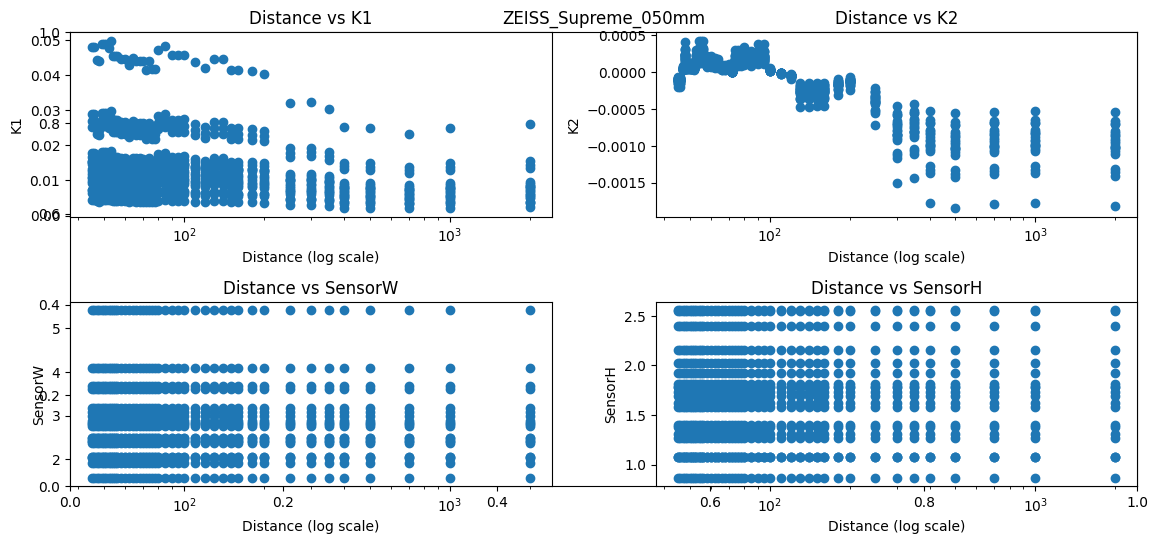

In [82]:
# prompt: Plot distance vs K1 K2 SensorW SensorH.  x-axis is log scale. y-axis is linear.

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'training_data' is your DataFrame with 'Distance', 'K1', 'K2', 'SensorW', 'SensorH'
# You might need to adjust column names based on your actual data.

if not training_data.empty:
    plt.figure(figsize=(12, 6))
    plt.title(lens)

    plt.subplot(2, 2, 1)
    plt.scatter(training_data['Distance'], training_data['K1'])
    plt.xscale('log')
    plt.xlabel('Distance (log scale)')
    plt.ylabel('K1')
    plt.title('Distance vs K1')

    plt.subplot(2, 2, 2)
    plt.scatter(training_data['Distance'], training_data['K2'])
    plt.xscale('log')
    plt.xlabel('Distance (log scale)')
    plt.ylabel('K2')
    plt.title('Distance vs K2')


    plt.subplot(2, 2, 3)
    plt.scatter(training_data['Distance'], training_data['SensorW'])
    plt.xscale('log')
    plt.xlabel('Distance (log scale)')
    plt.ylabel('SensorW')
    plt.title('Distance vs SensorW')


    plt.subplot(2, 2, 4)
    plt.scatter(training_data['Distance'], training_data['SensorH'])
    plt.xscale('log')
    plt.xlabel('Distance (log scale)')
    plt.ylabel('SensorH')
    plt.title('Distance vs SensorH')


    plt.tight_layout()
    plt.show()
else:
    print("No valid data to plot.")

# Parse the hidden data

In [83]:
# Function to extract columns and remove rows with zeroes in K1 or K2, or missing data
def extract_and_filter_hidden_csv_files(path):
    all_data = []

    try:
        # Read each CSV file
        df = pd.read_csv(path)
        all_data.append(df)
    except Exception as e:
        print(f"Error processing {path.name}: {e}")

    if all_data:
        # Concatenate all filtered dataframes into a single dataframe
        combined_data = pd.concat(all_data, ignore_index=True)
        return combined_data
    else:
        print("No valid data found.")
        return pd.DataFrame()  # Return an empty dataframe if no valid data

# Example usage:
hidden_data = extract_and_filter_hidden_csv_files(hiddencsv)

if not hidden_data.empty:
    print("Hidden data for " + hiddencsv + ":")
    print(hidden_data.head())
else:
    print("No hidden data to process.")

Hidden data for ./data/ZEISS_Supreme_050mm/lens_flame__ZEISS_Supreme_050mm__RED_Dragon_FF.hide:
   Distance        K1        K2  SensorW  SensorH
0      45.0  0.016031 -0.000116    3.072     1.58
1      46.0  0.016031 -0.000116    3.072     1.58
2      47.0  0.014755  0.000050    3.072     1.58
3      48.0  0.014616  0.000239    3.072     1.58
4      49.0  0.016235  0.000073    3.072     1.58


# Train using NN


## Ensure packages are installed

In [84]:
%%skip

!pip install keras-tuner tf2onnx

## Do the NN training

In [85]:
%%skip

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import numpy as np
import joblib
import os
from datetime import datetime
import random
import tf2onnx

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

if not training_data.empty and not training_data.isna().any().any():
    # Prepare the data for training
    X = training_data[['SensorW', 'SensorH', 'Distance']]
    y = training_data[['K1', 'K2']]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data using MinMaxScaler to normalize
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Save the scaler to use it during inference
    joblib.dump(scaler, os.path.join(lensdatadir, lens + '_scaler.pkl'))

    # Function to build the neural network model using Sequential API
    def build_model(hp):
        units = hp.Int('units', min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
        num_layers = hp.Int('num_layers', min_value=1, max_value=5)
        activation = hp.Choice('activation', ['relu'])
        batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)

        # Create optimizer instance
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

        # Build the Sequential model
        model = tf.keras.Sequential()
        model.output_names = ['output']
        model.add(tf.keras.Input(shape=(X_train.shape[1],)))

        # Add layers based on num_layers hyperparameter
        for _ in range(num_layers):
            model.add(tf.keras.layers.Dense(units, activation=activation))
            model.add(tf.keras.layers.Dropout(dropout_rate))

        # Output layer for K1, K2
        model.add(tf.keras.layers.Dense(2))

        # Compile the model with multi-objective loss
        def combined_loss(y_true, y_pred):
            k1_true, k2_true = y_true[:, 0], y_true[:, 1]
            k1_pred, k2_pred = y_pred[:, 0], y_pred[:, 1]
            k1_loss = tf.keras.losses.MeanSquaredError()(k1_true, k1_pred)
            k2_loss = tf.keras.losses.MeanSquaredError()(k2_true, k2_pred)
            return k1_loss + k2_loss

        model.compile(optimizer=optimizer, loss=combined_loss, metrics=['mae'])
        return model

    # Create a tuner for hyperparameter tuning using Bayesian Optimization
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=50,
        executions_per_trial=1,
        directory='tuner',
        project_name=lens,
        overwrite=True
    )

    # Run the hyperparameter search
    tuner.search(
        X_train, y_train,
        epochs=50,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')],
        verbose=2  # Set verbosity level
    )

    # Get the best hyperparameters and model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_hyperparameters = {
        'units': best_hps.get('units'),
        'dropout_rate': best_hps.get('dropout_rate'),
        'optimizer': best_hps.get('optimizer'),
        'learning_rate': best_hps.get('learning_rate'),
        'num_layers': best_hps.get('num_layers'),
        'activation': best_hps.get('activation'),
        'batch_size': best_hps.get('batch_size')
    }
    print('Best Hyperparameters:', best_hyperparameters)

    # Save the best hyperparameters to a text file with a date-stamped postfix
    timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
    hyperparams_file_path = os.path.join(lensdatadir, f'{lens}_best_hyperparameters_{timestamp}.txt')
    with open(hyperparams_file_path, 'w') as file:
        for key, value in best_hyperparameters.items():
            file.write(f'{key}: {value}\n')
        if best_hps.get('num_layers') > 1:
            units_per_layer = [best_hps.get(f'units_{i}') if i < best_hps.get('num_layers') else best_hps.get('units') for i in range(best_hps.get('num_layers'))]
            file.write(f'units_per_layer: {units_per_layer}')

    # Build the model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hps)

    # Train the best model
    history = best_model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=best_hps.get('batch_size'),
        validation_data=(X_test, y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')],
        verbose=2  # Set verbosity to reduce console output
    )

    # Evaluate the model
    loss, mae = best_model.evaluate(X_test, y_test)
    print('Mean Absolute Error:', mae)

    # Record the mae to the hyperparameter file
    with open(hyperparams_file_path, 'a') as file:
        file.write(f'Mean Absolute Error: {mae}\n')

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Function to plot predictions
    def plot_predictions(y_actual, y_pred, label, lens_name):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_actual, y_pred, label=f'{label} Predictions', alpha=0.6)
        plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
        plt.xlabel(f'Actual {label} Values')
        plt.ylabel(f'Predicted {label} Values')
        plt.title(f'{lens_name} Model Predictions vs Actual Values for {label}')
        plt.legend()
        plt.show()

    # Plot K1 and K2 predictions
    plot_predictions(y_test.values[:, 0], y_pred[:, 0], 'K1', lens)
    plot_predictions(y_test.values[:, 1], y_pred[:, 1], 'K2', lens)

    # Save the model
    modeldir = lensdatadir
    onnx_model_path = os.path.join(modeldir, lens + "_distortion_model.onnx")

    # Convert the model to ONNX using tf2onnx
    # Define the input signature manually
    input_signature = [tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float32)]

    # Convert the model to ONNX using tf2onnx with the input signature
    model_proto, _ = tf2onnx.convert.from_keras(best_model, input_signature=input_signature, opset=15)

    with open(onnx_model_path, "wb") as f:
        f.write(model_proto.SerializeToString())

    print(f"Model successfully saved to {onnx_model_path}")

else:
    print("No valid data to train the model.")


## Compare NN model to hidden data

In [86]:
%%skip

import matplotlib.pyplot as plt
import numpy as np

# Check if the hidden_data DataFrame is empty
if not hidden_data.empty:
    # Prepare the hidden data for testing
    X_hidden = hidden_data[['SensorW', 'SensorH', 'Distance']]
    y_hidden = hidden_data[['K1', 'K2']]

    # Scale the hidden data using the existing scaler
    X_hidden_scaled = scaler.transform(X_hidden)

    # Make predictions using the model
    y_pred_hidden = best_model.predict(X_hidden_scaled)

    # Convert predictions to DataFrame (only K1 and K2)
    y_pred_hidden_df = pd.DataFrame(y_pred_hidden[:, :2], columns=['K1_pred', 'K2_pred'])
    y_hidden.reset_index(drop=True, inplace=True)
    y_hidden_pred_combined = pd.concat([y_hidden, y_pred_hidden_df], axis=1)

    # Plotting actual vs predicted values for K1 and K2
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, col in enumerate(['K1', 'K2']):
        axes[i].scatter(y_hidden_pred_combined[col], y_hidden_pred_combined[f'{col}_pred'], alpha=0.6)
        axes[i].plot([y_hidden_pred_combined[col].min(), y_hidden_pred_combined[col].max()],
                     [y_hidden_pred_combined[col].min(), y_hidden_pred_combined[col].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'Actual {col}')
        axes[i].set_ylabel(f'Predicted {col}')
        axes[i].set_title(f'Actual vs Predicted {col}')

    plt.tight_layout()
    plt.show()

    # Calculate separate MAE for K1 and K2 on hidden_data
    mae_k1 = np.mean(np.abs(y_hidden['K1'] - y_pred_hidden_df['K1_pred']))
    mae_k2 = np.mean(np.abs(y_hidden['K2'] - y_pred_hidden_df['K2_pred']))
    print(f'Mean Absolute Error on hidden_data for K1: {mae_k1:.5f}')
    print(f'Mean Absolute Error on hidden_data for K2: {mae_k2:.5f}')

else:
    print("No valid data in hidden_data to evaluate the model.")


In [87]:
%%skip

# prompt: Scatter plot the predicted K1 K2 values given Distance SensorW SensorH on top of the actual values from the hidden_data

if not hidden_data.empty and 'K1' in hidden_data.columns and 'K2' in hidden_data.columns:
    # Prepare the hidden data for testing
    X_hidden = hidden_data[['SensorW', 'SensorH', 'Distance']]
    y_hidden = hidden_data[['K1', 'K2']]

    # Scale the hidden data using the existing scaler
    X_hidden_scaled = scaler.transform(X_hidden)

    # Make predictions using the model
    y_pred_hidden = best_model.predict(X_hidden_scaled)

    # Plotting actual vs predicted values for K1 and K2
    plt.figure(figsize=(10, 5))
    plt.scatter(hidden_data['Distance'], hidden_data['K1'], label='Actual K1', alpha=0.6)
    plt.scatter(hidden_data['Distance'], y_pred_hidden[:, 0], label='Predicted K1', alpha=0.6)
    plt.xlabel('Distance')
    plt.ylabel('K1')
    plt.title('Actual vs Predicted K1 on hidden data')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(hidden_data['Distance'], hidden_data['K2'], label='Actual K2', alpha=0.6)
    plt.scatter(hidden_data['Distance'], y_pred_hidden[:, 1], label='Predicted K2', alpha=0.6)
    plt.xlabel('Distance')
    plt.ylabel('K2')
    plt.title('Actual vs Predicted K2 on hidden data')
    plt.legend()
    plt.show()
else:
    print("No valid data in hidden_data to plot.")

## Write the predictions for the hidden data to a CSV

In [88]:
%%skip

import pandas as pd
from IPython.display import display

def display_distance_k_values(hidden_data):
    if not hidden_data.empty:
        # Extract relevant columns
        distance_k_table = hidden_data[['Distance', 'SensorW', 'SensorH', 'K1', 'K2']]

        # Sort the table by Distance for better readability
        distance_k_table_sorted = distance_k_table.sort_values(by='Distance').reset_index(drop=True)

        # Round values to the nearest 5th decimal
        distance_k_table_sorted = distance_k_table_sorted.round(5)

        # Display the table
        display(distance_k_table_sorted)

        # Write the table to a text file with formatting
        # get the hiddencsv file name without path or extension
        hiddencsv_filename = os.path.splitext(os.path.basename(hiddencsv))[0]
        file_path = f"{lensdatadir}{lens}_{hiddencsv_filename}_distance_k_table.txt"
        with open(file_path, 'w') as file:
            file.write("Distance      SensorW     SensorH   K1        K2\n")
            file.write("--------------------------------\n")
            for _, row in distance_k_table_sorted.iterrows():
                file.write(f"{row['Distance']:>10.5f} {row['SensorW']:>10.5f} {row['SensorH']:>10.5f} {row['K1']:>10.5f} {row['K2']:>10.5f}\n")
        print("Data written to ", file_path)
    else:
        print("No valid data in hidden_data to display.")

# Call the method
display_distance_k_values(hidden_data)

# Train with Gradient boosting

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mean Absolute Error for K1: 0.0002617023560871495
Mean Absolute Error for K2: 7.787254954398739e-05


,Distance,SensorW,SensorH,Predicted_K1,Predicted_K2
0,45.0,3.072,1.58,0.01630,0.00001
1,46.0,3.072,1.58,0.01630,0.00001
2,47.0,3.072,1.58,0.01537,0.00009
3,48.0,3.072,1.58,0.01537,0.00009
4,49.0,3.072,1.58,0.01643,0.00009
5,50.0,3.072,1.58,0.01643,0.00009
6,51.0,3.072,1.58,0.01643,0.00009
7,52.0,3.072,1.58,0.01643,0.00009
8,53.0,3.072,1.58,0.01643,0.00009
9,54.0,3.072,1.58,0.01555,0.00009


Data written to  ./data/ZEISS_Supreme_050mm/ZEISS_Supreme_050mm_lens_flame__ZEISS_Supreme_050mm__RED_Dragon_FF_gb_distance_k_table.txt


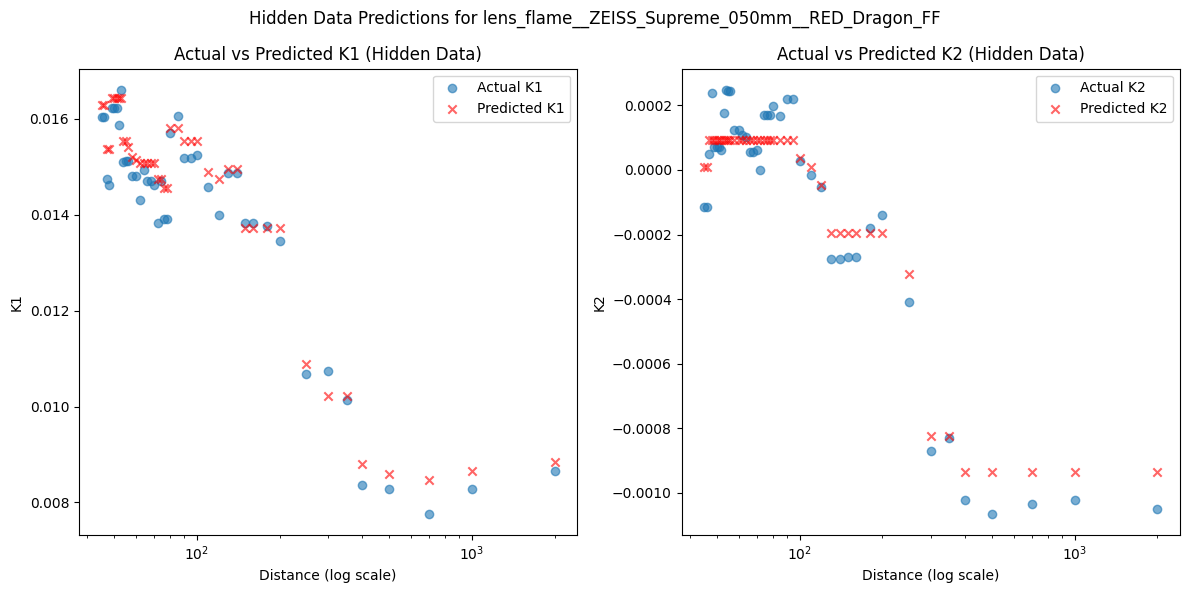

Distance 45.0
SensorW 3.072
SensorH 1.58
Predicted K1: 0.016295548528432846
Predicted K2: 1.0380706953583285e-05


c:\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [89]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display

# Set seeds for reproducibility
np.random.seed(42)

# Assuming training_data is already loaded and cleaned
if not training_data.empty and not training_data.isna().any().any():
    # Prepare the data for training
    X = training_data[['SensorW', 'SensorH', 'Distance']]
    y = training_data[['K1', 'K2']]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save the scaler
    scaler_path = os.path.join(lensdatadir, lens + '_scaler.pkl')
    joblib.dump(scaler, scaler_path)

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    # Initialize the base XGBoost Regressor
    base_model = XGBRegressor(random_state=42)

    # Perform RandomizedSearchCV for K1
    random_search_k1 = RandomizedSearchCV(estimator=base_model, param_distributions=param_grid,
                                          n_iter=20, scoring='neg_mean_absolute_error',
                                          cv=3, verbose=1, random_state=42, n_jobs=-1)
    random_search_k1.fit(X_train_scaled, y_train['K1'])
    model_k1 = random_search_k1.best_estimator_

    # Perform RandomizedSearchCV for K2
    random_search_k2 = RandomizedSearchCV(estimator=base_model, param_distributions=param_grid,
                                          n_iter=20, scoring='neg_mean_absolute_error',
                                          cv=3, verbose=1, random_state=42, n_jobs=-1)
    random_search_k2.fit(X_train_scaled, y_train['K2'])
    model_k2 = random_search_k2.best_estimator_

    # Evaluate the models
    k1_pred = model_k1.predict(X_test_scaled)
    k2_pred = model_k2.predict(X_test_scaled)

    k1_mae = np.mean(np.abs(y_test['K1'] - k1_pred))
    k2_mae = np.mean(np.abs(y_test['K2'] - k2_pred))

    print(f'Mean Absolute Error for K1: {k1_mae}')
    print(f'Mean Absolute Error for K2: {k2_mae}')

    # Save the models
    modeldir = lensdatadir
    pk1modelpath = os.path.join(modeldir, lens + '_model_k1.pkl')
    pk2modelpath = os.path.join(modeldir, lens + '_model_k2.pkl')
    joblib.dump(model_k1, pk1modelpath)
    joblib.dump(model_k2, pk2modelpath)

    # Record the MAE to a text file with a date-stamped postfix
    timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
    mae_file_path = os.path.join(lensdatadir, f'{lens}_mae_{timestamp}.txt')
    with open(mae_file_path, 'w') as file:
        file.write(f'Mean Absolute Error for K1: {k1_mae}\n')
        file.write(f'Mean Absolute Error for K2: {k2_mae}\n')
else:
    print("No valid data to train the model.")

# Function to write hidden data predictions to CSV
def save_hidden_data_predictions(hidden_data):
    if not hidden_data.empty:
        # Prepare the hidden data for prediction
        X_hidden = hidden_data[['SensorW', 'SensorH', 'Distance']]

        # Load the scaler and transform the hidden data
        scaler = joblib.load(scaler_path)
        X_hidden_scaled = scaler.transform(X_hidden)

        # Make predictions using the loaded models
        k1_pred = model_k1.predict(X_hidden_scaled)
        k2_pred = model_k2.predict(X_hidden_scaled)

        # Create a new DataFrame with the relevant columns and predictions
        predictions_df = hidden_data[['Distance', 'SensorW', 'SensorH']].copy()
        predictions_df['Predicted_K1'] = k1_pred
        predictions_df['Predicted_K2'] = k2_pred

        # Sort the table by Distance for better readability
        distance_k_table_sorted = predictions_df.sort_values(by='Distance').reset_index(drop=True)

        # Round values to the nearest 5th decimal
        distance_k_table_sorted = distance_k_table_sorted.round(5)

        # Display the table
        display(distance_k_table_sorted)

        # Write the table to a text file with formatting
        hiddencsv_filename = os.path.splitext(os.path.basename(hiddencsv))[0]
        file_path = f"{lensdatadir}{lens}_{hiddencsv_filename}_gb_distance_k_table.txt"
        with open(file_path, 'w') as file:
            file.write("Distance      SensorW     SensorH   Predicted_K1  Predicted_K2\n")
            file.write("---------------------------------------------\n")
            for _, row in distance_k_table_sorted.iterrows():
                file.write(f"{row['Distance']:>10.5f} {row['SensorW']:>10.5f} {row['SensorH']:>10.5f} {row['Predicted_K1']:>10.5f} {row['Predicted_K2']:>10.5f}\n")
        print("Data written to ", file_path)
    else:
        print("No valid data in hidden_data to display.")

# Call the function
save_hidden_data_predictions(hidden_data)

def scatter_plot_hidden_data_predictions(hidden_data, scaler_path, model_k1, model_k2, lensdatadir, hiddencsv):
    if not hidden_data.empty:
        # Prepare the hidden data for prediction
        X_hidden = hidden_data[['SensorW', 'SensorH', 'Distance']]

        # Load the scaler and transform the hidden data
        scaler = joblib.load(scaler_path)
        X_hidden_scaled = scaler.transform(X_hidden)

        # Make predictions using the loaded models
        k1_pred = model_k1.predict(X_hidden_scaled)
        k2_pred = model_k2.predict(X_hidden_scaled)

        # Scatter plot the predicted values on top of the actual values
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Hidden Data Predictions for {os.path.splitext(os.path.basename(hiddencsv))[0]}')
        plt.subplot(1, 2, 1)
        plt.scatter(hidden_data['Distance'], hidden_data['K1'], label='Actual K1', alpha=0.6)
        plt.scatter(hidden_data['Distance'], k1_pred, label='Predicted K1', alpha=0.6, marker='x', color='red')
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('K1')
        plt.title('Actual vs Predicted K1 (Hidden Data)')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(hidden_data['Distance'], hidden_data['K2'], label='Actual K2', alpha=0.6)
        plt.scatter(hidden_data['Distance'], k2_pred, label='Predicted K2', alpha=0.6, marker='x', color='red')
        plt.xscale('log')
        plt.xlabel('Distance (log scale)')
        plt.ylabel('K2')
        plt.title('Actual vs Predicted K2 (Hidden Data)')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(lensdatadir, f'{lens}_hidden_data_predictions.png'))
        plt.show()
    else:
        print("No hidden data to plot.")

# Call the function to scatter plot hidden data predictions
scatter_plot_hidden_data_predictions(hidden_data, scaler_path, model_k1, model_k2, lensdatadir, hiddencsv)

def make_prediction(distance, sensorw, sensorh, pk1modelpath, pk2modelpath, scaler_path):
    """
    Loads the trained models and scaler, and makes a prediction for K1 and K2.

    Args:
        distance: The distance value.
        sensorw: The SensorW value.
        sensorh: The SensorH value.
        pk1modelpath: The path to the K1 model.
        pk2modelpath: The path to the K2 model.
        scaler_path: The path to the scaler.

    Returns:
        A tuple containing the predicted K1 and K2 values.
    """

    # Load the models
    model_k1 = joblib.load(pk1modelpath)
    model_k2 = joblib.load(pk2modelpath)

    # Load the scaler
    scaler = joblib.load(scaler_path)

    # Prepare the input data
    input_data = [[sensorw, sensorh, distance]]
    input_data_scaled = scaler.transform(input_data)

    # Make predictions using the loaded models
    k1_pred = model_k1.predict(input_data_scaled)[0]
    k2_pred = model_k2.predict(input_data_scaled)[0]

    return k1_pred, k2_pred

# Example usage:
# get distance sensorw sensorh from first row of hidden_data
distance = hidden_data.iloc[0]['Distance']
sensorw = hidden_data.iloc[0]['SensorW']
sensorh = hidden_data.iloc[0]['SensorH']

k1_pred, k2_pred = make_prediction(distance, sensorw, sensorh, pk1modelpath, pk2modelpath, scaler_path)

print(f"Distance {hidden_data.iloc[0]['Distance']}")
print(f"SensorW {hidden_data.iloc[0]['SensorW']}")
print(f"SensorH {hidden_data.iloc[0]['SensorH']}")

print(f"Predicted K1: {k1_pred}")
print(f"Predicted K2: {k2_pred}")
